# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
#arc = pd.read_csv('C:/datasets/data_arc.csv')
#bulk = pd.read_csv('C:/datasets/data_bulk.csv')
#bulk_time = pd.read_csv('C:/datasets/data_bulk_time.csv')
#gas = pd.read_csv('C:/datasets/data_gas.csv')
#temp = pd.read_csv('C:/datasets/data_temp.csv')
#wire = pd.read_csv('C:/datasets/data_wire.csv')
#wire_time = pd.read_csv('C:/datasets/data_wire_time.csv')  

## Анализ данных

In [4]:
#функция для получения информации о датасете
def info_data(data):
    display (data.head())
    display (data.info())
    display (data.describe())
    print ('Уникальных партий:', len(data['key'].unique()))

### Arc — данные об электродах

In [5]:
info_data(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Уникальных партий: 3214


- всего 14876 значений итераций обработки в 3214 партиях
- в среднем на каждую партию приходится 4,6 итераций
- пропусков в данных нет
- в данных о "Реактивной мощности" прослеживается явный выброс в минусовых значениях. Посмотрим эти данные

In [6]:
print('Количество отрицательных значений  в колонке "Реактивная мощность":',
      len([item for item in arc['Реактивная мощность'] if item < 0]))

Количество отрицательных значений  в колонке "Реактивная мощность": 1


In [7]:
ind = int(arc[arc['Реактивная мощность'] <=0].index.values)
display(arc.iloc[ind-3:ind+3])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9777,2115,2019-07-24 00:21:20,2019-07-24 00:22:21,0.259949,0.175169
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796
9782,2117,2019-07-24 01:06:01,2019-07-24 01:07:57,0.443970,0.367739


В данном случае прослеживается ошибка в данных. Какое значение должно быть фактически, мы не можем скзать. Единственное о чем можно сделать вывод, что реактивная мощность на этой итерации снижалась, а так же что реактивная мощность по результатам прочих наблюдений составляет 60-70% от активной мощности. Предлагаю заменить ошибочные данные на значение активной мощности с поправочным коэффициентом, который будет равен среднему % отклонению активной и реактивной мощнастей.

In [8]:
mean_activ=arc['Активная мощность'].mean()
mean_reactiv=arc['Реактивная мощность'].sum()/len([item for item in arc['Реактивная мощность'] if item > 0])   
k_reactiv = mean_reactiv/mean_activ
arc.loc[ind,'Реактивная мощность'] = arc.loc[ind,'Активная мощность'] * k_reactiv
print('Новое значение "Реактивной мощности" в', ind, 'строке:', arc.loc[ind,'Реактивная мощность'])

Новое значение "Реактивной мощности" в 9780 строке: 0.3347080373509705


### Bulk — данные о подаче сыпучих материалов 

In [9]:
info_data(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Уникальных партий: 3129


In [10]:
info_data(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Уникальных партий: 3129


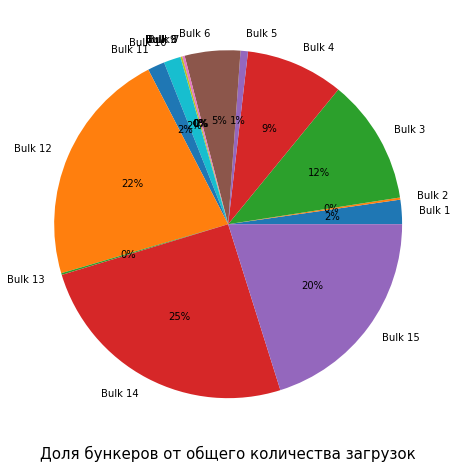

In [11]:
non_null_bulk=pd.DataFrame(bulk[['Bulk %s' % i for i in range(1, 16)]].count(axis=0))
plt.figure(figsize=(8,8))
plt.pie(non_null_bulk[0], labels=non_null_bulk.index, autopct='%.0f%%')
plt.xlabel('Доля бункеров от общего количества загрузок', fontsize=15)
plt.show()

- количество уникальных партий, а так же non-null объектов по 2 базам совпадает
- как видим количество уникальных номеров партий сократилось с 3214 до 3129, на 2,6%
- связано это с отсутсвием данных о подаче сыпучих материалов в сплав. Возможно это отсутствие связано с технологическим процессом. В дальнейшем уберем партии без полных данных из нашей финальной выборки.
- так же мы видим большое количество пропусков, связано это скорее всего с технологическим процессом.
- так же можно обратить внимание, что на 6 бункеров приходится 93% всех случаев добавления присадок.
- в дальнейшим предлагаю избавится от оставшихся 8 признаков во избежания переобучения модели и снижения ресурсоемкости, так как данным по ним мало (до 2% от выборки на каждый признак) и перед нами не стоит задача классификации.
- так же я не вижу какую практическую роль здесь может сыграть для нашей задачи время добавления сыпучих веществ в бункер, так как судя из данных, большая часть из них добавляется на 1 стадии нагрева, а оставшиеся материалы в основном на предпоследней стадии. Поэтому, что бы не перегружать модель, будем считать эти данные избыточными и, в дальнейшем, не учитывать их

### Wire — данные о проволочных материалах 

In [12]:
info_data(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Уникальных партий: 3081


In [13]:
info_data(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Уникальных партий: 3081


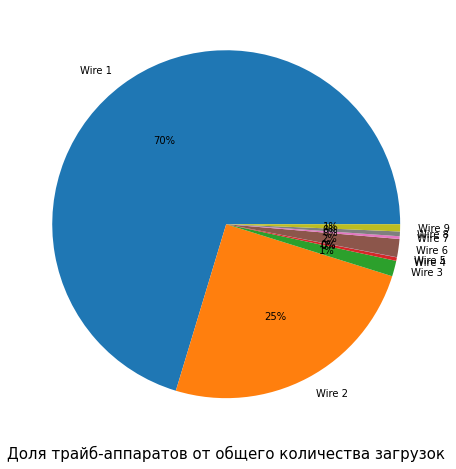

In [14]:
non_null_wire = pd.DataFrame(wire[['Wire %s' % i for i in range(1, 10)]].count(axis=0))
plt.figure(figsize=(8,8))
plt.pie(non_null_wire[0], labels=non_null_wire.index, autopct='%.0f%%')
plt.xlabel('Доля трайб-аппаратов от общего количества загрузок', fontsize=15)
plt.show()

- с проволкой просматривается аналогичная ситуация как и с сыпучими материалами
- кол-во уникальных партий еще сократилось и составило 3081
- 95% всех добавок приходятся на 2 признака
- так же предлагаю избавиться от оставшихся 7 признаков, и так же не принимать в расчет время внесения провалки в сплав

### Gas — данные о продувке сплава газом

In [15]:
info_data(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Уникальных партий: 3239


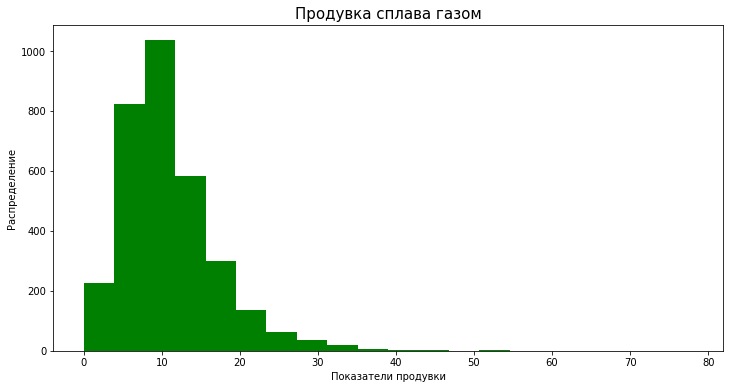

In [16]:
plt.figure(figsize=(12,6))
plt.hist((gas['Газ 1']), bins=20, color='g')
plt.title('Продувка сплава газом', fontsize=15)
plt.xlabel('Показатели продувки')
plt.ylabel('Распределение')
plt.show()

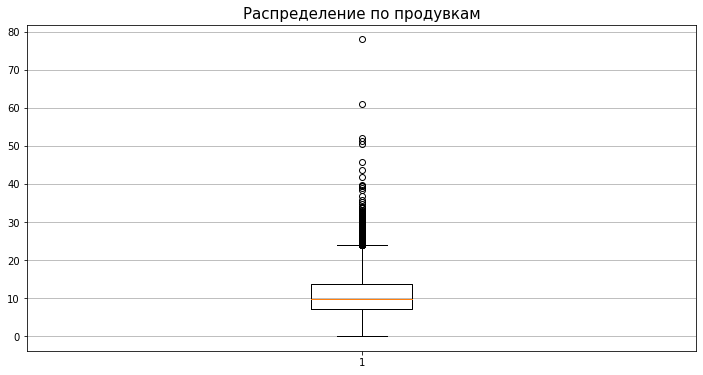

In [17]:
plt.figure(figsize=(12,6))
plt.boxplot(gas['Газ 1'])
plt.grid(axis='y')
plt.title('Распределение по продувкам', fontsize=15)
plt.show()

In [18]:
print('% выбросов', round(gas[gas['Газ 1']>25].count()/len(gas)*100, 2))

% выбросов key      3.12
Газ 1    3.12
dtype: float64


- имеется некоторое количество выбросов = 3,12%, 101 партия
- предлагаю избавиться от этих строк, для большего приближения к нормальному распределению

### Temp — результаты измерения температуры

In [19]:
info_data(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Уникальных партий: 3216


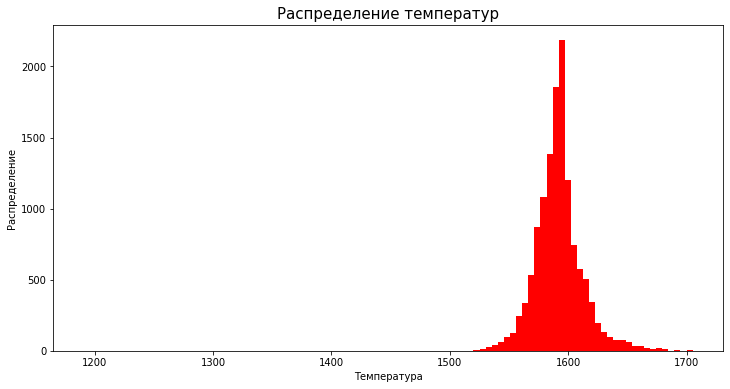

In [20]:
plt.figure(figsize=(12,6))
plt.hist((temp['Температура']), bins=100, color='r')
plt.title('Распределение температур', fontsize=15)
plt.xlabel('Температура')
plt.ylabel('Распределение')
plt.show()

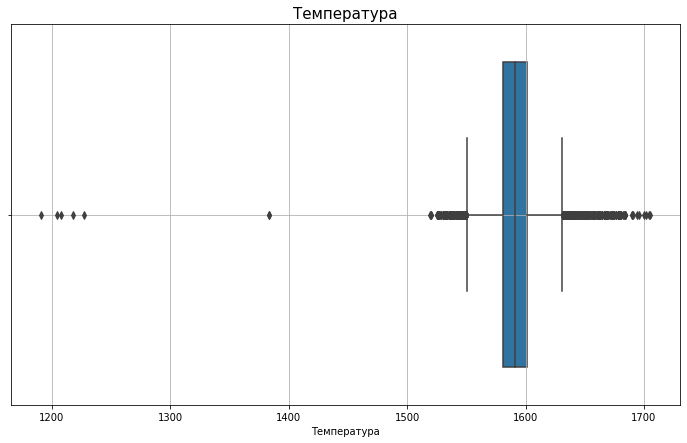

In [21]:
plt.figure(figsize=(12,7))
sns.boxplot(temp['Температура'])
plt.title('Температура', fontsize=15)
plt.grid(True)
plt.show()

In [22]:
print('% выбросов', round((temp[temp['Температура']>=1650].count()+temp[temp['Температура']<=1550].count())/len(temp)*100, 2))

% выбросов key             2.72
Время замера    2.72
Температура     2.72
dtype: float64


- имеются 2.72% выбросов по столбцу "Температура"
- избавимся от них в дальнейшем, для приближения к нормальному распределению
- так же имеься 2901 пропуск в данных, посмотрим их:

In [23]:
temp[temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [24]:
temp_2500 = temp[temp['key']>=2500]
temp_2500 = temp_2500[temp_2500['Температура']>0]
temp_2500['key'].value_counts().head()

3072    1
2829    1
2820    1
2821    1
2822    1
Name: key, dtype: int64

- все пропуски втречаются после 2500 партии
- в 3638 итерациях 2901 пропуск
- по этим партиям известна лишь температура на входе, после 1-ой итерации
- потери в данных по партиям составляют почти 23%

## ПЛАН РАБОТЫ

1. убрать из Temp все партии в которых отстутствует целевой признак
2. создать общий датасет с ключом по номеру партии
3. ввести доп.параметры: общее время нагрева, кол-во итераций в партии, возможно полную мощность
4. "почистить" выборку: 
- избавляемся от избыточных признаков в Bulk и Wire
- проверяем данные на мультиколлинеарность, при необходимости убираем лишние признаки
- убираем все признаки, которые не влияют на целевой признак, например, номер партии
5. разделить выборку на обучающую и тестовую.
6. масштабируем количественные признаки
7. создаем и тестируем модели: линейная регрессия, случайный лес, LGBM
8. подбираем гиперпараметры к моделям
9. определяем лучшую модель на основании показателей метрики MAE. Целевые значения MAE:
(> 8.7 — 0 sp, 7.6 < MAE ≤ 8.7 — 4 sp, 6.8 < MAE ≤ 7.6 — 4.5 sp, 6.3 < MAE ≤ 6.8 — 5 sp, 6.0 < MAE ≤ 6.3 — 5.5 sp, MAE ≤ 6.0 — 6 sp)

## Вопросы к тимлиду:

- насколько критично для технологии время внесения сыпучки и проволки? судя по набору данных эти значения избыточны, т.е. можно их игнорировать.  
- есть-ли смысл вводить параметр полной мощности, если там большинство данных по мощностям будет мультиколлинеарным?  
- часть признаков занимает менее 1% от выборки. правильно ли будет избавиться от них, так как явно объема датасета не достаточно для обучения на этих признаках. Или лучше "раздуть" датасет каким-либо методом?

## Преобразование данных

In [25]:
#убираем из все партии в которых отстутствует целевой признак
arc = arc.query('key < 2500')

In [27]:
#Преобразуем формат данных на datetime
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

In [28]:
#избавляемся от избыточных признаков
wire = wire [['key', 'Wire 1', 'Wire 2']]
bulk = bulk [['key', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']]

In [29]:
#вводим новые параметры
arc['Продолжительность нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']) // pd.Timedelta('1s')
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

In [30]:
#группируем по столбцу key
arc_count = arc['key'].value_counts().sort_index().reset_index()
arc_count = arc_count.rename(columns={'index': 'key', 'key': 'Количество запусков'})
arc = arc.groupby(by = 'key', as_index=False).sum()
arc = arc.merge(arc_count, how='left', on='key')

In [31]:
#проверка на мультиколленерарность
display(arc[['Активная мощность', 'Реактивная мощность', 'Продолжительность нагрева', 'Полная мощность',
       'Количество запусков']].corr())

,Активная мощность,Реактивная мощность,Продолжительность нагрева,Полная мощность,Количество запусков
Активная мощность,1.000000,0.959714,0.978183,0.993675,0.754084
Реактивная мощность,0.959714,1.000000,0.966453,0.985065,0.751363
Продолжительность нагрева,0.978183,0.966453,1.000000,0.982893,0.795824
Полная мощность,0.993675,0.985065,0.982893,1.000000,0.760277
Количество запусков,0.754084,0.751363,0.795824,0.760277,1.000000


- между собой коррелируют: активная мощность, реактивная мощность, продолжительность нагрева и полная мощность 
- это приведет к переобучению модели
- оставляем признак наиболее коррелеруемый с сотальными - полная мощность
- от остальных избавляемся

In [32]:
#избавляемся от мультиколинеарных данных
arc = arc[['key', 'Полная мощность', 'Количество запусков']]

In [33]:
#определяеи стартовую и окончательную температуры по партиям
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = ['key', '1', '2', 'temp_start', 'temp_finish']
temp = temp[['key', 'temp_start', 'temp_finish']]

In [34]:
#объединяем в общий датасет
df = (arc.merge(temp, how='left', on='key')
         .merge(wire, how='left', on='key')
         .merge(bulk, how='left', on='key')
         .merge(gas, how='left', on='key'))

In [35]:
df = df.drop(['key'], axis = 1)
df = df.fillna(0)

In [36]:
#проверяем итоговые данные на мультиколинеарность
display(df.corr())

,Полная мощность,Количество запусков,temp_start,temp_finish,Wire 1,Wire 2,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Газ 1
Полная мощность,1.000000,0.760277,-0.323045,0.221919,0.034270,0.043921,0.105725,-0.018277,0.155238,0.478345,0.452739,0.323548,0.371926
Количество запусков,0.760277,1.000000,-0.176449,0.050266,0.182710,0.084672,0.129923,0.023483,0.164286,0.317826,0.345431,0.217214,0.416007
temp_start,-0.323045,-0.176449,1.000000,0.376621,0.071876,-0.103083,-0.126958,0.098172,-0.116663,-0.068498,-0.154557,-0.115456,-0.001326
temp_finish,0.221919,0.050266,0.376621,1.000000,-0.066263,-0.205057,-0.086867,0.049758,-0.173874,0.161748,0.006859,0.008165,-0.033076
Wire 1,0.034270,0.182710,0.071876,-0.066263,1.000000,-0.010373,0.084719,0.318095,-0.179843,0.169770,0.000092,0.204983,0.161702
Wire 2,0.043921,0.084672,-0.103083,-0.205057,-0.010373,1.000000,0.099578,-0.250216,0.201639,-0.097572,0.029338,-0.074952,0.112754
Bulk 3,0.105725,0.129923,-0.126958,-0.086867,0.084719,0.099578,1.000000,-0.268084,0.074755,0.036251,0.039236,0.027576,0.080453
Bulk 4,-0.018277,0.023483,0.098172,0.049758,0.318095,-0.250216,-0.268084,1.000000,-0.232155,0.119985,-0.052717,0.140136,0.038209
Bulk 6,0.155238,0.164286,-0.116663,-0.173874,-0.179843,0.201639,0.074755,-0.232155,1.000000,-0.095454,0.186873,-0.074241,0.148112
Bulk 12,0.478345,0.317826,-0.068498,0.161748,0.169770,-0.097572,0.036251,0.119985,-0.095454,1.000000,0.505135,0.607225,0.227448


In [38]:
df = df.rename(columns={'Полная мощность': 'full_power', 'Количество запусков':'number_heat', 'Газ 1': 'gas'})

In [39]:
#делим на выборки
x, y = train_test_split(df, test_size = .25, random_state = 12345)

In [40]:
#масштабируем выборки
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ('temp_finish')]
scaler = MinMaxScaler()
scaler.fit(x[numeric])

x[numeric] = scaler.transform(x[numeric])
y[numeric] = scaler.transform(y[numeric])

In [41]:
x_train = x.drop(['temp_finish'], axis = 1)
y_train = x['temp_finish']
x_test = y.drop(['temp_finish'], axis = 1)
y_test = y['temp_finish']

## Модели

### Linear Regression

In [42]:
%%time
param_lr_grid = {'fit_intercept':[True, False], 
                 'normalize':[True, False]
                }

grid_lr = GridSearchCV(LinearRegression(), 
                       param_lr_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error',
                       )

grid_lr.fit(x_train, y_train)
params_lr = grid_lr.best_params_
lr = LinearRegression(**params_lr)
lr.fit(x_train, y_train)
pred_test = lr.predict(x_test)
print(params_lr)
print('MAE на тестовой выборке: ', mean_absolute_error(y_test, pred_test))

{'fit_intercept': True, 'normalize': False}
MAE на тестовой выборке:  8.131199083830797
CPU times: user 158 ms, sys: 124 ms, total: 282 ms
Wall time: 204 ms


Text(0.5, 0, 'Linear Regression: важность признаков')

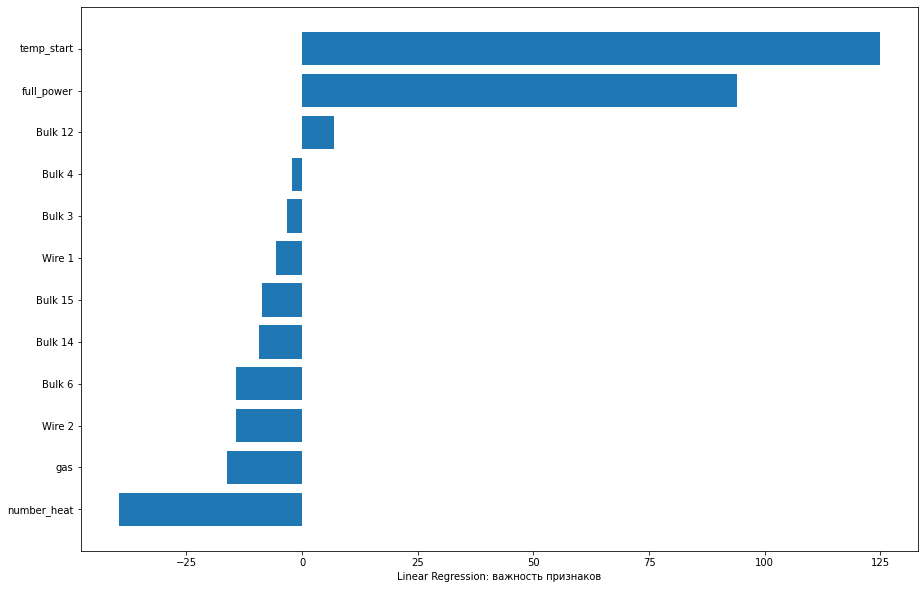

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = lr.coef_.argsort()
plt.barh(x_test.columns.values[sorted_idx], lr.coef_[sorted_idx])
plt.xlabel('Linear Regression: важность признаков')

### Random Forest

In [44]:
%%time
param_rf_grid = {'n_estimators': [50, 100, 200, 300], 
                 'max_depth': [2, 3, 5], 
                 'min_samples_split': [2, 3, 5], 
                 'max_features': ['auto'],
                }
grid_rf = GridSearchCV(RandomForestRegressor(random_state=12345), 
                       param_rf_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(x_train, y_train)
params_rf = grid_rf.best_params_
rf = RandomForestRegressor(**params_rf, random_state=12345)
rf.fit(x_train, y_train)
pred_test = rf.predict(x_test)
print(params_rf)
print('MAE на тестовой выборке: ', mean_absolute_error(y_test, pred_test))

{'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 3, 'n_estimators': 50}
MAE на тестовой выборке:  6.88067831560668
CPU times: user 1min 20s, sys: 374 ms, total: 1min 20s
Wall time: 1min 20s


Text(0.5, 0, 'Random Forest: важность признаков')

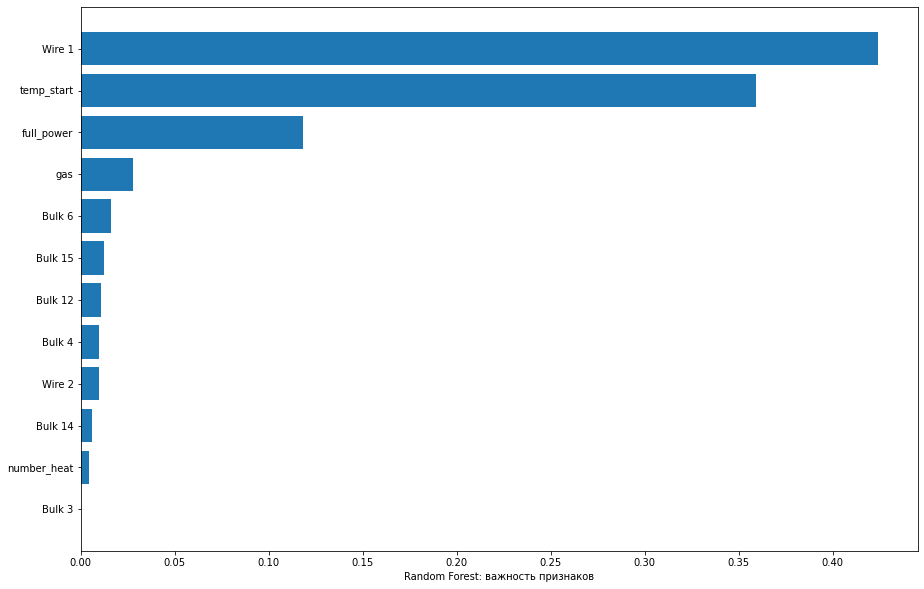

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_test.columns.values[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel('Random Forest: важность признаков')

### LGBMRegressor

In [48]:
%%time
param_lgbm_grid = {'boosting_type' : ['gbdt'],
                  'n_estimators': [500, 1000, 1250], 
                  'learning_rate': [0.01, 0.02, 0.03],
                  'max_depth':[2, 3, 4],
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=12345), 
                        param_lgbm_grid, 
                        cv=10, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_lgbm.fit(x_train, y_train)
params_lgbm = grid_lgbm.best_params_
lgbm = LGBMRegressor(**params_lgbm)
lgbm.fit(x_train, y_train)
pred_test = lgbm.predict(x_test) 
print(params_lgbm)
print("MAE on test: ", mean_absolute_error(y_test, pred_test))

{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
MAE on test:  6.631669407676265
CPU times: user 12min 10s, sys: 3.24 s, total: 12min 14s
Wall time: 13min 57s


Text(0.5, 0, 'LGBMRegressor: важность признаков')

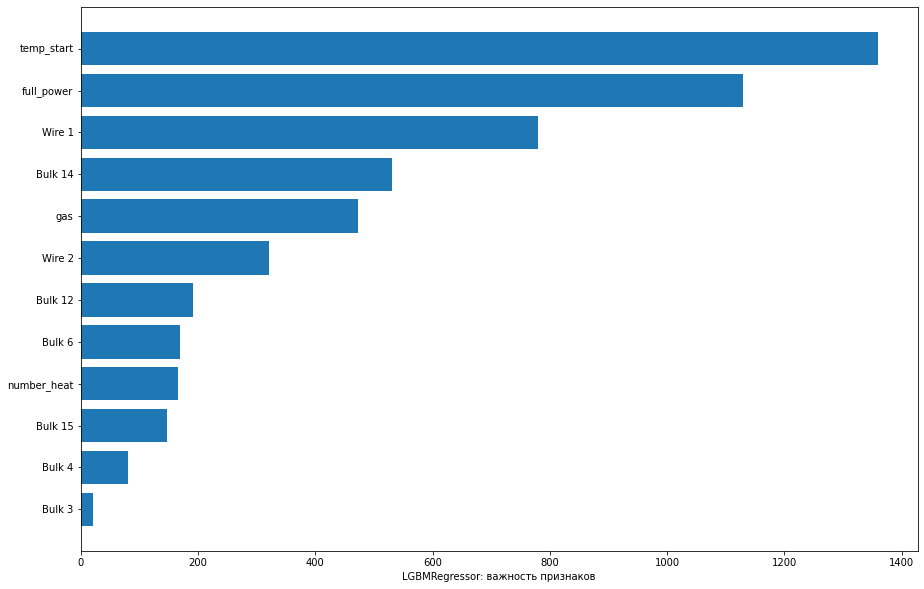

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = lgbm.feature_importances_.argsort()
plt.barh(x_test.columns.values[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.xlabel('LGBMRegressor: важность признаков')

## Выводы

- подготовили данные и обучили модели
- определили важность признаков для каждой модели
- с помощью метрики MAE сравнили их эффективность
- лучший результат у модели LGBMRegressor: MAE на тесте: 6.43

## Отчет

убрать из Temp все партии в которых отстутствует целевой признак  
**выполнено**  
создать общий датасет с ключом по номеру партии  
**выполнено**  
ввести доп.параметры: общее время нагрева, кол-во итераций в партии, возможно полную мощность
**выполнено**    
"почистить" выборку:  
избавляемся от избыточных признаков в Bulk и Wire  
**выполнено**    
проверяем данные на мультиколлинеарность, при необходимости убираем лишние признаки  
**выполнено**  
убираем все признаки, которые не влияют на целевой признак, например, номер партии  
**выполнено**  
разделить выборку на обучающую и тестовую.  
**выполнено**  
масштабируем количественные признаки  
**выполнено**  
создаем и тестируем модели: линейная регрессия, случайный лес, LGBM  
**выполнено**  
подбираем гиперпараметры к моделям  
**выполнено**  
определяем лучшую модель на основании показателей метрики MAE. Целевые значения MAE: (> 8.7 — 0 sp, 7.6 < MAE ≤ 8.7 — 4 sp, 6.8 < MAE ≤ 7.6 — 4.5 sp, 6.3 < MAE ≤ 6.8 — 5 sp, 6.0 < MAE ≤ 6.3 — 5.5 sp, MAE ≤ 6.0 — 6 sp)  
**выполнено**  

**- в задумках так же было выкинуть выбросы из обычающей выборке, но последующий анализ показал снижение MAE на тесте в моделе LGBMRegressor**  
**- так же можно  улучшить итоговую MAE если не "выбрасывать" данные из data_bulk и data_wire, однако это в на порядок увеличивает время обсчета модели, так как у нас не стояла задача максимального увеличения точности, то я оставил в приоритете модель с оптимальном значеинем качество\время**
**- как выше я у же обозначал, не хватает данных на входе для более точного предсказания, а имеено хим.состава изначального сырья**  
**- имея его мы могли бы проверить множество гипотез воияющие на нагрев, а именно время внесения доп. компонентов, влияние их объема на нагрев, заивимость от количества итераций от нагрева и множества других. Имея только данные из задачи, данные показатели мы не можем предсказать с большой вероятномтью, так как фактически не зная всех данных на входе, последующие данные для нас становятся "рандомные"**  
**- на практике, имея такие данные как в проекте, я бы предложил попробывать обучение без учителя и просто разбить на кластеры, так как все равно температура конечная будет колебаться. А там уже смотреть какие факторы нам нужно корректировать, что бы был переход между категориями**